### Import Libraries

In [1]:
from transformers import Trainer, TrainingArguments, RobertaTokenizer, RobertaForSequenceClassification
from time import time
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, lr_scheduler
from torch import __version__,tensor,save
from torch import cuda
from torch.utils.data import Dataset
import torch
from tqdm import tqdm
import math
import os
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.nn.functional as F
import pandas as pd

c:\Users\Yassin\Desktop\NLP\Homeworks\HW2\AIReveal\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
__version__

'2.3.0+cu118'

In [2]:
if cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
device

device(type='cuda')

### Custom Trainer

In [ ]:
class CustomTrainer(Trainer):
    def _inner_training_loop(self, batch_size=None, args=None, resume_from_checkpoint=False, trial=None, ignore_keys=None):
        self.model.to(device)
        number_of_epochs = args.num_train_epochs
        start = time()
        train_loss=[]
        train_acc=[]
        eval_acc=[]

        criterion = CrossEntropyLoss().to(torch.device(device=device))
        self.optimizer = Adam(self.model.parameters(), lr=args.learning_rate)
        self.scheduler = lr_scheduler.StepLR(self.optimizer, 1, gamma=0.9)

        train_dataloader = self.get_train_dataloader()
        eval_dataloader = self.get_eval_dataloader()

        max_steps = math.ceil(args.num_train_epochs * len(train_dataloader))

        # Checkpoint Directory
        checkpoint_dir = os.path.join(args.output_dir,"checkpoints")
        os.makedirs(checkpoint_dir,exist_ok=True)

        start_epoch = 0
        if resume_from_checkpoint:
            checkpoint = torch.load(os.path.join(resume_from_checkpoint, "training_state.pth"), map_location=device)

            # Ensure model loads on correct device
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.model.to(device) 
            
            # Ensure optimizer tensors are moved to correct device
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            for param_group in self.optimizer.param_groups:
                param_group["params"] = [p.to(device) for p in param_group["params"]]

            self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            start_epoch = checkpoint['epoch'] + 1
            print(f"Resuming from checkpoint {resume_from_checkpoint} at epoch {start_epoch}, using device: {device}")




        for epoch in range(start_epoch,number_of_epochs):
            train_loss_per_epoch = 0
            train_acc_per_epoch = 0
            with tqdm(train_dataloader, unit="batch") as training_epoch:
                training_epoch.set_description(f"Training Epoch {epoch}") 
                for step, inputs in enumerate(training_epoch):
                    inputs = {key: val.to(device) for key, val in inputs.items()}
                    labels = inputs['labels'].to(device)
                    # forward pass
                    self.optimizer.zero_grad()
                    output = self.model(**inputs)

                    loss = criterion(output['logits'], labels)
                    
                    train_loss_per_epoch += loss.item()

                    #calculate gradients
                    loss.backward()
                    #update weights
                    self.optimizer.step()
                    train_acc_per_epoch += (output['logits'].argmax(1) == labels).sum().item()
            # adjust the learning rate
            self.scheduler.step()
            train_loss_per_epoch /= len(train_dataloader)
            train_acc_per_epoch /= (len(train_dataloader)*batch_size)
            train_loss.append(train_loss_per_epoch)
            train_acc.append(train_acc_per_epoch)


            eval_loss_per_epoch = 0
            eval_acc_per_epoch = 0
            with tqdm(eval_dataloader, unit="batch") as eval_epoch:
                eval_epoch.set_description(f"Evaluation Epoch {epoch}")
                for step, inputs in enumerate(eval_epoch):
                    inputs = {key: val.to(device) for key, val in inputs.items()}
                    labels = inputs['labels'].to(device)
                    # forward pass
                    output = self.model(**inputs)
                    # get the loss
                    loss = criterion(output['logits'], labels)
                    eval_loss_per_epoch += loss.item()

                    eval_acc_per_epoch += (output['logits'].argmax(1) == labels).sum().item()
            eval_loss_per_epoch /= (len(eval_dataloader))
            eval_acc_per_epoch /= (len(eval_dataloader)*batch_size)
            eval_acc.append(eval_acc_per_epoch)

            print(f'\tTrain Loss: {train_loss_per_epoch:.3f} | Train Acc: {train_acc_per_epoch*100:.2f}%')
            print(f'\tEval Loss: {eval_loss_per_epoch:.3f} | Eval Acc: {eval_acc_per_epoch*100:.2f}%')

            checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint-epoch-{epoch}")
            os.makedirs(checkpoint_path, exist_ok=True)

            save({
                'epoch': epoch,
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'scheduler_state_dict': self.scheduler.state_dict()
            }, os.path.join(checkpoint_path, "training_state.pth"))

            print(f"Checkpoint saved at {checkpoint_path}")



        print(f'Time: {(time()-start)/60:.3f} minutes')
        return train_loss, train_acc, eval_acc
    

    def validate_checkpoint(self, checkpoint_path=None): # Created this function to validate each checkpoint since  my validation during training was not enough
        if checkpoint_path:
            print(f"Loading checkpoint from {checkpoint_path} for validation...")
            checkpoint = torch.load(os.path.join(checkpoint_path, "training_state.pth"), map_location=device)

            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.model.to(device) 

        self.model.eval()

        all_preds = []
        all_labels = []
        eval_loss_per_epoch = 0
        criterion = CrossEntropyLoss().to(device)

        eval_dataloader = self.get_eval_dataloader()

        with tqdm(eval_dataloader, unit="batch") as eval_epoch:
            eval_epoch.set_description(f"Validating Checkpoint: {checkpoint_path if checkpoint_path else 'Current Model'}")
            for step, inputs in enumerate(eval_epoch):
                inputs = {key: val.to(device) for key, val in inputs.items()}
                labels = inputs['labels'].to(device)

                # Forward pass (no gradients needed)
                with torch.no_grad():
                    output = self.model(**inputs)

                # loss
                loss = criterion(output['logits'], labels)
                eval_loss_per_epoch += loss.item()

                # Store predictions and labels
                preds = output['logits'].argmax(1).detach().cpu().tolist() 
                all_preds.extend(preds)

                labels = labels.detach().cpu().tolist() 
                all_labels.extend(labels)


        # Compute evaluation metrics
        eval_loss_per_epoch /= len(eval_dataloader)
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average="binary")
        recall = recall_score(all_labels, all_preds, average="binary")
        f1 = f1_score(all_labels, all_preds, average="binary")

        print(f"\nValidation Results for {checkpoint_path if checkpoint_path else 'Current Model'}:")
        print(f"\tEval Loss: {eval_loss_per_epoch:.3f}")
        print(f"\tEval Accuracy: {accuracy * 100:.2f}% | Precision: {precision:.3f} | Recall: {recall:.3f} | F1-Score: {f1:.3f}")
        
        return {"loss": eval_loss_per_epoch, "accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


### Training Args Prep

### Load Data

In [ ]:
train = load_dataset("yaful/MAGE", split="train")
valid = load_dataset("yaful/MAGE", split="validation")

### Check Data

In [ ]:
train_df = train.to_pandas()
valid_df = valid.to_pandas()

In [49]:
test = load_dataset("yaful/MAGE", split="test")
test_df = test.to_pandas()

In [11]:
train_df.head()

,text,label,src
0,White girls very rarely date Asian men. Even i...,1,cmv_human
1,I am a 23 year old male Indian American male. ...,1,cmv_human
2,"Take three people, Persons A, B, and C. They l...",1,cmv_human
3,(A) Work part-time in high school; Then go to ...,1,cmv_human
4,When police introduce a new form of speed prev...,1,cmv_human


In [12]:
train_df['label'].unique()

array([1, 0])

In [13]:
train_df.drop('src',axis=1,inplace=True) # Dropped the src column as it's not useful in my case

In [14]:
train_df.head(10)

,text,label
0,White girls very rarely date Asian men. Even i...,1
1,I am a 23 year old male Indian American male. ...,1
2,"Take three people, Persons A, B, and C. They l...",1
3,(A) Work part-time in high school; Then go to ...,1
4,When police introduce a new form of speed prev...,1
5,I love to eat Asiatic food but I could never r...,1
6,"In the argument against gay marriage, people o...",1
7,So first of I am danish. That means that I fol...,1
8,In this post I am going to be very blunt. This...,1
9,Here's what I see in my neighborhood which has...,1


In [15]:
# Checking if it's balanced
train_df['label'].value_counts()
# The Data is unbalanced towards the AI gen content

label
0    225753
1     93318
Name: count, dtype: int64

In [16]:
train_df[train_df['label']==0].head()

,text,label
7165,White girls very rarely date Asian men. Even i...,0
7166,I am a 23 year old male Indian American male. ...,0
7167,"Take three people, Persons A, B, and C. They l...",0
7168,(A) Work part-time in high school; Then go to ...,0
7169,When police introduce a new form of speed prev...,0


### Preprocess the Data

Custom Dataset

In [19]:
class CustomTextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = tensor(self.labels[idx])
        return item

Loading Model and Tokenizer

In [20]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
def preprocess_function(data):
    return tokenizer(data, padding="max_length", truncation=True, return_tensors="pt")


In [22]:
#Tokenize the data
tokenized_train = train_df['text'].apply(preprocess_function)
tokenized_valid = valid_df['text'].apply(preprocess_function)


In [23]:
def convert_to_dict(encodings):
    input_ids = [e["input_ids"].squeeze(0).tolist() for e in encodings]
    attention_mask = [e["attention_mask"].squeeze(0).tolist() for e in encodings]
    return {"input_ids": input_ids, "attention_mask": attention_mask}


In [24]:
train_encodings = convert_to_dict(tokenized_train)
valid_encodings = convert_to_dict(tokenized_valid)

In [25]:
# Convert train and valid datasets to custom datasets
train_dataset = CustomTextDataset(train_encodings, train_df["label"].tolist())
valid_dataset = CustomTextDataset(valid_encodings, valid_df["label"].tolist())

In [26]:
output_dir = '../output'
os.makedirs(output_dir, exist_ok=True)

### Hyper Params

In [3]:
BATCH_SIZE = 8
NUM_EPOCHS = 4
LR = 1e-5

In [28]:
training_args = TrainingArguments(
    num_train_epochs=NUM_EPOCHS,
    learning_rate=LR,
    output_dir=output_dir,
)


### Fine-Tuning

In [59]:
trainer = CustomTrainer(model=model, train_dataset=train_dataset, eval_dataset=valid_dataset)

In [ ]:
train_loss, train_acc, eval_acc = trainer._inner_training_loop(batch_size=BATCH_SIZE, args=training_args)

The error here is just because of the time module but nothing affected the training. (I didn't clear the cell output for you to check my results)

In [31]:
train_loss, train_acc, eval_acc = trainer._inner_training_loop(batch_size=BATCH_SIZE, args=training_args, resume_from_checkpoint='../output/checkpoints/checkpoint-epoch-0')

Resuming from checkpoint ../output/checkpoints/checkpoint-epoch-0 at epoch 1, using device: cuda


Evaluation Epoch 1: 100%|██████████| 7099/7099 [07:18<00:00, 16.18batch/s]


	Train Loss: 0.044 | Train Acc: 98.35%
	Eval Loss: 0.156 | Eval Acc: 94.81%
Checkpoint saved at ../output\checkpoints\checkpoint-epoch-1


Evaluation Epoch 2: 100%|██████████| 7099/7099 [07:19<00:00, 16.17batch/s]


	Train Loss: 0.022 | Train Acc: 99.22%
	Eval Loss: 0.153 | Eval Acc: 95.19%
Checkpoint saved at ../output\checkpoints\checkpoint-epoch-2


Evaluation Epoch 3: 100%|██████████| 7099/7099 [07:33<00:00, 15.67batch/s]


	Train Loss: 0.012 | Train Acc: 99.58%
	Eval Loss: 0.197 | Eval Acc: 94.94%
Checkpoint saved at ../output\checkpoints\checkpoint-epoch-3


AttributeError: 'builtin_function_or_method' object has no attribute 'time'

In [ ]:
# I Put them manually since the code crashed due to time.time() and my import was from time import time ;(
train_loss = [0.067,0.044,0.022,0.012]
train_acc = [97.02,98.35,99.22,99.58]
eval_acc = [90.32,94.81,95.19,94.94]

In [13]:
import matplotlib.pyplot as plt

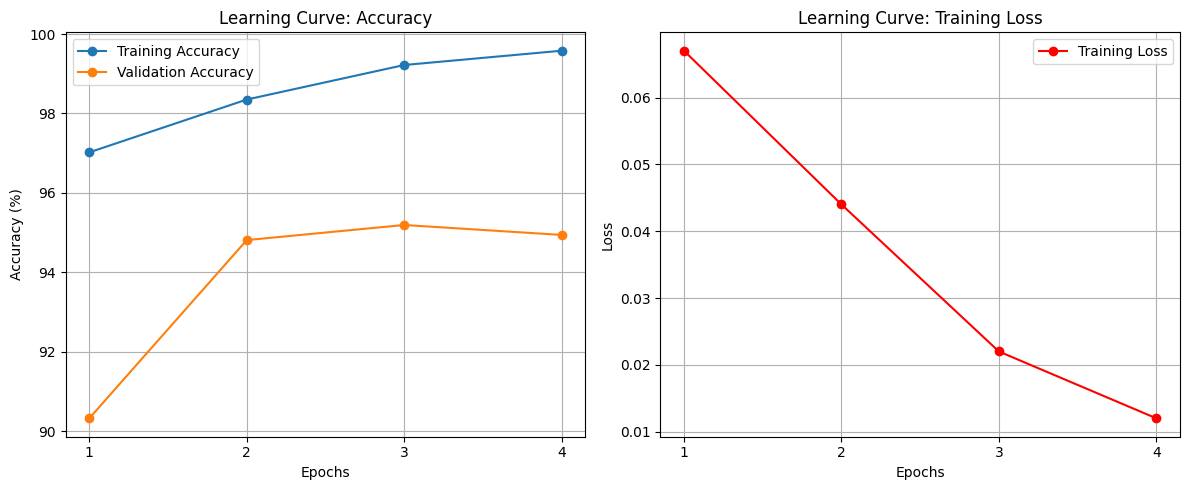

In [ ]:

epochs = range(1, NUM_EPOCHS + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 

axes[0].plot(epochs, train_acc, label="Training Accuracy", marker="o")
axes[0].plot(epochs, eval_acc, label="Validation Accuracy", marker="o")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy (%)")
axes[0].set_title("Learning Curve: Accuracy")
axes[0].legend()
axes[0].grid()
axes[0].set_xticks(epochs)

axes[1].plot(epochs, train_loss, label="Training Loss", marker="o", color="red")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].set_title("Learning Curve: Training Loss")
axes[1].legend()
axes[1].grid()
axes[1].set_xticks(epochs)

plt.tight_layout()
plt.show()


Training time : 576 mins

### Training Evaluation (Since during training I didn't do it quite well)

https://arxiv.org/pdf/1907.11692 (new eval metrics)

In [52]:
checkpoint_path = "../output/checkpoints/checkpoint-epoch-"


In [60]:
for i in range(4):
    trainer.validate_checkpoint(checkpoint_path=checkpoint_path+str(i))

Loading checkpoint from ../output/checkpoints/checkpoint-epoch-0 for validation...


Validating Checkpoint: ../output/checkpoints/checkpoint-epoch-0: 100%|██████████| 7099/7099 [3:04:07<00:00,  1.56s/batch]  



Validation Results for ../output/checkpoints/checkpoint-epoch-0:
	Eval Loss: 0.158
	Eval Accuracy: 93.65% | Precision: 0.978 | Recall: 0.895 | F1-Score: 0.935
Loading checkpoint from ../output/checkpoints/checkpoint-epoch-1 for validation...


Validating Checkpoint: ../output/checkpoints/checkpoint-epoch-1: 100%|██████████| 7099/7099 [2:51:59<00:00,  1.45s/batch]  



Validation Results for ../output/checkpoints/checkpoint-epoch-1:
	Eval Loss: 0.156
	Eval Accuracy: 94.81% | Precision: 0.969 | Recall: 0.928 | F1-Score: 0.948
Loading checkpoint from ../output/checkpoints/checkpoint-epoch-2 for validation...


Validating Checkpoint: ../output/checkpoints/checkpoint-epoch-2: 100%|██████████| 7099/7099 [2:36:01<00:00,  1.32s/batch]  



Validation Results for ../output/checkpoints/checkpoint-epoch-2:
	Eval Loss: 0.153
	Eval Accuracy: 95.19% | Precision: 0.950 | Recall: 0.956 | F1-Score: 0.953
Loading checkpoint from ../output/checkpoints/checkpoint-epoch-3 for validation...


Validating Checkpoint: ../output/checkpoints/checkpoint-epoch-3: 100%|██████████| 7099/7099 [2:33:07<00:00,  1.29s/batch]  


Validation Results for ../output/checkpoints/checkpoint-epoch-3:
	Eval Loss: 0.197
	Eval Accuracy: 94.94% | Precision: 0.962 | Recall: 0.938 | F1-Score: 0.950


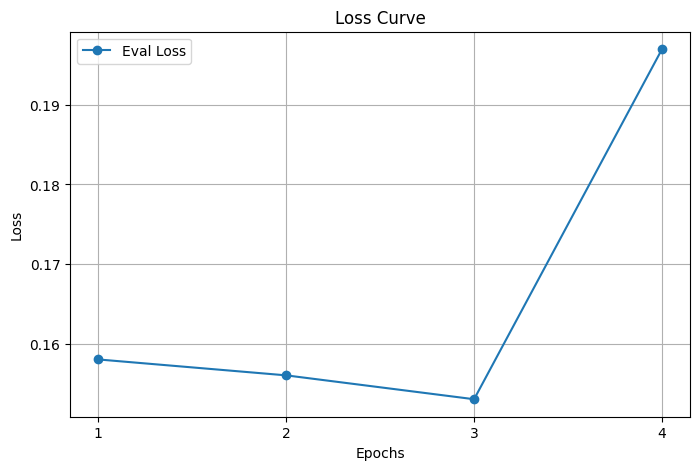

In [5]:
import matplotlib.pyplot as plt

eval_loss = [0.158, 0.156, 0.153, 0.197]  # Entered manually
epochs = range(1, len(eval_loss) + 1)  # Ensuring the correct range

plt.figure(figsize=(8, 5))
plt.plot(epochs, eval_loss, label="Eval Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid()
plt.xticks(epochs) 
plt.show()


As we can observe the model starts overfitting after the third epoch

### Testing

In [48]:
def test_RoBerta(model,data):
    # Loading the model (model is the path to the checkpoint I will test, my plan is to test the last two checkpoints (I hope my GPU makes it :') )
    model = model
    model.to(device)
    model.eval()
    
    tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
    inp = tokenizer(data, return_tensors="pt", padding="max_length", truncation=True)
    inp ={key:val.to(device) for key,val in inp.items()}
    with torch.no_grad():
        outputs = model(**inp)

    logits = outputs.logits
    probabilities = F.softmax(logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    prob_class_1 = probabilities[0, 1].item()

    return {"predicted_label": predicted_class, "prob_class_1": prob_class_1}

In [82]:
test_df.head()

,text,label,src
0,Little disclaimer: this deals with US laws and...,1,cmv_human
1,"Read: Mentally Retarded Downs. See, we've got ...",1,cmv_human
2,"If any of you frequent rbadhistory, there is a...",1,cmv_human
3,"I believe in a flat tax system, where everyone...",1,cmv_human
4,"Edit: Ok guy's, my views have been changed on ...",1,cmv_human


In [52]:
def load_model_from_checkpoint(checkpoint_path):

    model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    # Load model weights
    model.load_state_dict(checkpoint["model_state_dict"],strict=False)
    model.to(device)
    model.eval()

    return model


In [55]:
fine_tuned_model_checkpoint_path = "../output/checkpoints/checkpoint-epoch-2/training_state.pth"
fine_tuned_model = load_model_from_checkpoint(fine_tuned_model_checkpoint_path)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
test_df[["predicted", "prob_class_1"]] = test_df["text"].apply(lambda x: pd.Series(test_RoBerta(fine_tuned_model, x)))

In [57]:
test_df.head()

,text,label,src,predicted,prob_class_1
0,Little disclaimer: this deals with US laws and...,1,cmv_human,1.0,0.999922
1,"Read: Mentally Retarded Downs. See, we've got ...",1,cmv_human,1.0,0.999907
2,"If any of you frequent rbadhistory, there is a...",1,cmv_human,1.0,0.999922
3,"I believe in a flat tax system, where everyone...",1,cmv_human,1.0,0.999914
4,"Edit: Ok guy's, my views have been changed on ...",1,cmv_human,1.0,0.999920


In [58]:
# Will add a missclassified column
test_df["is_misclassified"] = (test_df["label"] != test_df["predicted"].astype(int)).astype(int)

In [59]:
test_df[test_df["is_misclassified"] == 1].head()

,text,label,src,predicted,prob_class_1,is_misclassified
64,"Torrents download in chunks, and once you've d...",1,eli5_human,0.0,0.011204,1
129,Earthly is a build automation tool that execut...,1,tldr_human,0.0,0.045311,1
172,The seahorse placenta is a fascinating example...,1,tldr_human,0.0,0.444996,1
176,This article tells the story of how a team gen...,1,tldr_human,0.0,0.270547,1
187,"When starting out in a career, it's okay to ma...",1,tldr_human,0.0,0.192105,1


In [60]:
test_df.to_csv("../data/Fine-Tuned_Roberta_test/predictions_probs")

In [95]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

def evaluate_predictions(y_true,y_pred,y_probs=None):
    y_true = list(y_true)
    y_pred = list(y_pred)

    # Compute accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Compute precision, recall, and F1-score (weighted average)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    auroc = roc_auc_score(y_true, y_probs) if y_probs is not None else None


    return {
        "accuracy": round(accuracy, 4),
        "precision": round(precision, 4),
        "recall": round(recall, 4),
        "f1_score": round(f1, 4),
        "auroc" : round(auroc,2) if auroc is not None else None
    }

    

In [96]:
print(evaluate_predictions(test_df["label"],test_df["predicted"],test_df["prob_class_1"]))

{'accuracy': 0.9306, 'precision': 0.9311, 'recall': 0.9306, 'f1_score': 0.9306, 'auroc': 0.98}


In [94]:
from sklearn.metrics import recall_score

hum_samples = test_df[test_df["label"] == 1]
hum_rec = recall_score(hum_samples["label"],hum_samples["predicted"])

# Did it manually since the recall_score returns 0
ai_samples = test_df[test_df["label"] == 0]
true_positives = ((ai_samples["label"] == 0) & (ai_samples["predicted"] == 0)).sum()
false_negatives = ((ai_samples["label"] == 0) & (ai_samples["predicted"] == 1)).sum()

ai_rec = true_positives / (true_positives + false_negatives)

print(f"Hum Rec: {hum_rec:.4f}\nAI Rec: {ai_rec:.4f}\nAVG Rec: {round((hum_rec+ai_rec)/2,4)}")


Hum Rec: 0.9467
AI Rec: 0.9147
AVG Rec: 0.9307


In [91]:
print(ai_samples["predicted"].value_counts())


predicted
0.0    27878
1.0     2600
Name: count, dtype: int64


### Testing other LLMs

I will test using Qwen2.5 and RoBerta-base

VLLM Needs a Linux Machine, and I am working on a windows machine, and can't use colab since I am having a problem with my card ans still trying to fix it.

### Qwen2.5-1.5B

In [55]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
# referred to https://huggingface.co/docs/transformers/en/model_doc/qwen2
model_name = "Qwen/Qwen2.5-1.5B" 
qwen_tokenizer = AutoTokenizer.from_pretrained(model_name)
llm_qwen = AutoModelForCausalLM.from_pretrained(model_name, num_labels=2)
llm_qwen.to(device)
llm_qwen.eval()

def classify_qwen(text):
    prompt = f"Answer with only a single number: 0 for AI-generated or 1 for human-written. Text: {text} \nAnswer:"
        
    inputs = qwen_tokenizer(prompt, return_tensors="pt",padding=True, truncation=True).to(device)

    with torch.no_grad():
        outputs = llm_qwen.generate(**inputs, max_new_tokens=10, temperature=0.1, top_p=0.5)
    
    if outputs is None or len(outputs) == 0:
        return "Error"
    response = qwen_tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
    response = response.split("Answer:")[-1].strip()
    if response not in ["0","1"]:
        return "error"
    return int(response)


In [19]:
test_df = pd.read_csv('../data/Fine-Tuned_RoBerta_test/predictions')

In [49]:
test_df.head()

,Unnamed: 0,text,label,src,predicted,confidence,is_misclassified
0,0,Little disclaimer: this deals with US laws and...,1,cmv_human,1,0.999964,0
1,1,"Read: Mentally Retarded Downs. See, we've got ...",1,cmv_human,1,0.999964,0
2,2,"If any of you frequent rbadhistory, there is a...",1,cmv_human,1,0.999964,0
3,3,"I believe in a flat tax system, where everyone...",1,cmv_human,1,0.999964,0
4,4,"Edit: Ok guy's, my views have been changed on ...",1,cmv_human,1,0.999964,0


In [ ]:
test_subset = test_df.sample(frac=0.1, random_state=42) # I took a 10% sample since the whole test set is taking too much time (estimated for the whole test set on my gpu: 20hrs)

In [65]:
len(test_subset)

6074

In [66]:
test_subset.head()

,Unnamed: 0,text,label,src,predicted,confidence,is_misclassified
21764,21764,Never again...never again!!' This place is ter...,0,yelp_machine_continuation_t0_3b,0,0.999959,0
46722,46722,"put the carpet on the floor, they measure it, ...",1,hswag_human,1,0.986834,0
49245,49245,[substeps] You may do this process before you ...,1,hswag_human,1,0.986236,0
30867,30867,"I believe mandatory minimum laws are unjust, c...",1,cmv_human,1,0.999964,0
10010,10010,Wales coach Warren Gatland has hailed Shane Wi...,0,xsum_machine_specified_text-davinci-003,0,0.999966,0


In [67]:
tqdm.pandas()
test_subset["qwen"] = test_subset["text"].progress_apply(classify_qwen)

  0%|          | 0/6074 [00:00<?, ?it/s]c:\Users\Yassin\Desktop\NLP\Homeworks\HW2\AIReveal\.venv\lib\site-packages\transformers\generation\configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\Yassin\Desktop\NLP\Homeworks\HW2\AIReveal\.venv\lib\site-packages\transformers\generation\configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
100%|██████████| 6074/6074 [3:53:49<00:00,  2.31s/it]


In [68]:
test_subset["is_missclassified_qwen"] = (test_subset["label"] != test_subset["qwen"]).astype(int)

In [69]:
test_subset.to_csv('../data/Fine-Tuned_RoBerta_test/predictions_qwen')

In [70]:
test_subset.head()

,Unnamed: 0,text,label,src,predicted,confidence,is_misclassified,qwen,is_missclassified_qwen
21764,21764,Never again...never again!!' This place is ter...,0,yelp_machine_continuation_t0_3b,0,0.999959,0,1,1
46722,46722,"put the carpet on the floor, they measure it, ...",1,hswag_human,1,0.986834,0,1,0
49245,49245,[substeps] You may do this process before you ...,1,hswag_human,1,0.986236,0,0,1
30867,30867,"I believe mandatory minimum laws are unjust, c...",1,cmv_human,1,0.999964,0,1,0
10010,10010,Wales coach Warren Gatland has hailed Shane Wi...,0,xsum_machine_specified_text-davinci-003,0,0.999966,0,1,1


In [ ]:
test_subset = test_subset.loc[test_subset["qwen"] != "error"] # Removed all the rows with value error as their qwen classification, as this means the model didn't predict 0 or 1.

In [ ]:
test_subset[test_subset["qwen"]=="error"].shape[0] # Checking that there are no rows with predicted value of 0

0

In [ ]:
results_qwen = evaluate_predictions(y_true=test_subset["label"],y_pred=test_subset["qwen"]) # Qwen Results
print(results_qwen)

{'accuracy': 0.4912714097496706, 'precision': 0.4953035020352214, 'recall': 0.4912714097496706, 'f1_score': 0.38756575241568386}


In [ ]:
results = evaluate_predictions(y_true=test_subset["label"], y_pred=test_subset["predicted"]) # RoBerta Results
print(results)

{'accuracy': 0.9393939393939394, 'precision': 0.9394495831563205, 'recall': 0.9393939393939394, 'f1_score': 0.9393849393849394}


In [91]:


with open("../output/results/models_evaluation.txt", "w", encoding="utf-8") as f:
    f.write(f"Fine-Tuned RoBerta: {str(results)}\n")
    f.write(f"Qwen2.5-1.5: {str(results_qwen)}\n")


In [88]:
test_subset.to_csv("../output/results/test_results.csv")

### Missclassified Sample for the assignment spreadsheet

In [98]:
missclassified_df = pd.read_csv("../output/results/test_results")

In [99]:
missclassified_df.head()

,Unnamed: 0.1,Unnamed: 0,text,label,src,predicted,confidence,is_misclassified,qwen,is_missclassified_qwen
0,21764,21764,Never again...never again!!' This place is ter...,0,yelp_machine_continuation_t0_3b,0,0.999959,0,1,1
1,46722,46722,"put the carpet on the floor, they measure it, ...",1,hswag_human,1,0.986834,0,1,0
2,49245,49245,[substeps] You may do this process before you ...,1,hswag_human,1,0.986236,0,0,1
3,30867,30867,"I believe mandatory minimum laws are unjust, c...",1,cmv_human,1,0.999964,0,1,0
4,10010,10010,Wales coach Warren Gatland has hailed Shane Wi...,0,xsum_machine_specified_text-davinci-003,0,0.999966,0,1,1


In [103]:
missclassified_df = missclassified_df[(missclassified_df["is_misclassified"] == 1) | (missclassified_df["is_missclassified_qwen"] == 1)]

In [105]:
missclassified_df_both = missclassified_df[(missclassified_df["is_misclassified"] == 1) & (missclassified_df["is_missclassified_qwen"] == 1)]

In [107]:
len(missclassified_df_both)

171

In [112]:
missclassified_df_roberta = missclassified_df[(missclassified_df["is_misclassified"] == 1) & (missclassified_df["is_missclassified_qwen"] == 0)]
missclassified_df_qwen = missclassified_df[(missclassified_df["is_missclassified_qwen"] == 1) & (missclassified_df["is_misclassified"] == 0)]

In [113]:
(len(missclassified_df_roberta),len(missclassified_df_qwen))

(197, 2918)

In [ ]:
missclassified_df_both.to_csv("../output/results/misclassified/misclassified_both")
missclassified_df_roberta.to_csv("../output/results/misclassified/misclassified_roberta")
missclassified_df_qwen.to_csv("../output/results/misclassified/misclassified_qwen")

In [116]:
missclassified_df_both

,Unnamed: 0.1,Unnamed: 0,text,label,src,predicted,confidence,is_misclassified,qwen,is_missclassified_qwen
49,23965,23965,I love this place! The owner is an awesome guy...,0,yelp_machine_continuation_flan_t5_large,1,0.978829,1,1,1
88,59967,59967,Research on the precise influence of answering...,0,pubmed_gpt4_para,1,0.996392,1,1,1
110,44509,44509,Jasper is worried that baguettes are too crunc...,1,roct_human,0,0.782164,1,0,1
191,849,849,"I have hypothyroidism, PCOS, and used to be a ...",0,cmv_machine_continuation_t0_11b,1,0.922015,1,1,1
199,58726,58726,Closing arguments are imminent in Aaron Hernan...,0,cnn_gpt4_para,1,0.601037,1,1,1
...,...,...,...,...,...,...,...,...,...,...
5885,59716,59716,Patients with burn injuries may show an imbala...,0,pubmed_human_para,1,0.999963,1,1,1
5944,58765,58765,"Paulo Ferreira, a former Chelsea star, has sug...",0,cnn_gpt4_para,1,0.530430,1,1,1
6017,59244,59244,Maybe there is no other TV series that has mor...,0,imdb_human_para,1,0.999962,1,1,1
6047,5157,5157,"Hia, I'm no expert however I am a psychology s...",0,eli5_machine_continuation_30B,1,0.702165,1,1,1


In [118]:
missclassified_df_both["label"].value_counts()

label
0    148
1     23
Name: count, dtype: int64

In [135]:
misclassified_for_submission = missclassified_df_both[["text","src","label","predicted","confidence"]]

In [129]:
def classify_error(row):
    if row["label"] == 0 and row["predicted"] == 1:
        return "False Positive"
    elif row["label"] == 1 and row["predicted"] == 0:
        return "False Negative"
    else:
        return "Unknown"  # Just in case there's an unexpected value

# Apply the function to create the column
misclassified_for_submission["Error Type"] = misclassified_for_submission.apply(classify_error, axis=1)

C:\Users\Yassin\AppData\Local\Temp\ipykernel_16756\148241799.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_for_submission["Error Type"] = misclassified_for_submission.apply(classify_error, axis=1)


In [136]:
misclassified_for_submission.head()

,text,src,label,predicted,confidence
49,I love this place! The owner is an awesome guy...,yelp_machine_continuation_flan_t5_large,0,1,0.978829
88,Research on the precise influence of answering...,pubmed_gpt4_para,0,1,0.996392
110,Jasper is worried that baguettes are too crunc...,roct_human,1,0,0.782164
191,"I have hypothyroidism, PCOS, and used to be a ...",cmv_machine_continuation_t0_11b,0,1,0.922015
199,Closing arguments are imminent in Aaron Hernan...,cnn_gpt4_para,0,1,0.601037


In [137]:
misclassified_for_submission=misclassified_for_submission.sample(20)

In [138]:
misclassified_for_submission.to_csv("../output/results/misclassified/misclassified_excel.csv")